In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_t-drive/t-drive_cut.pkl')
fake = pd.read_pickle('../machine_learning/generated/citybased_rnn_2/GRU-32_TD-Dense-3_t-drive_64_100_adam_mae_default_cut.pkl')

In [3]:
# Load the OSMNX graphs
streets_beijing = ox.load_graphml('beijing_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

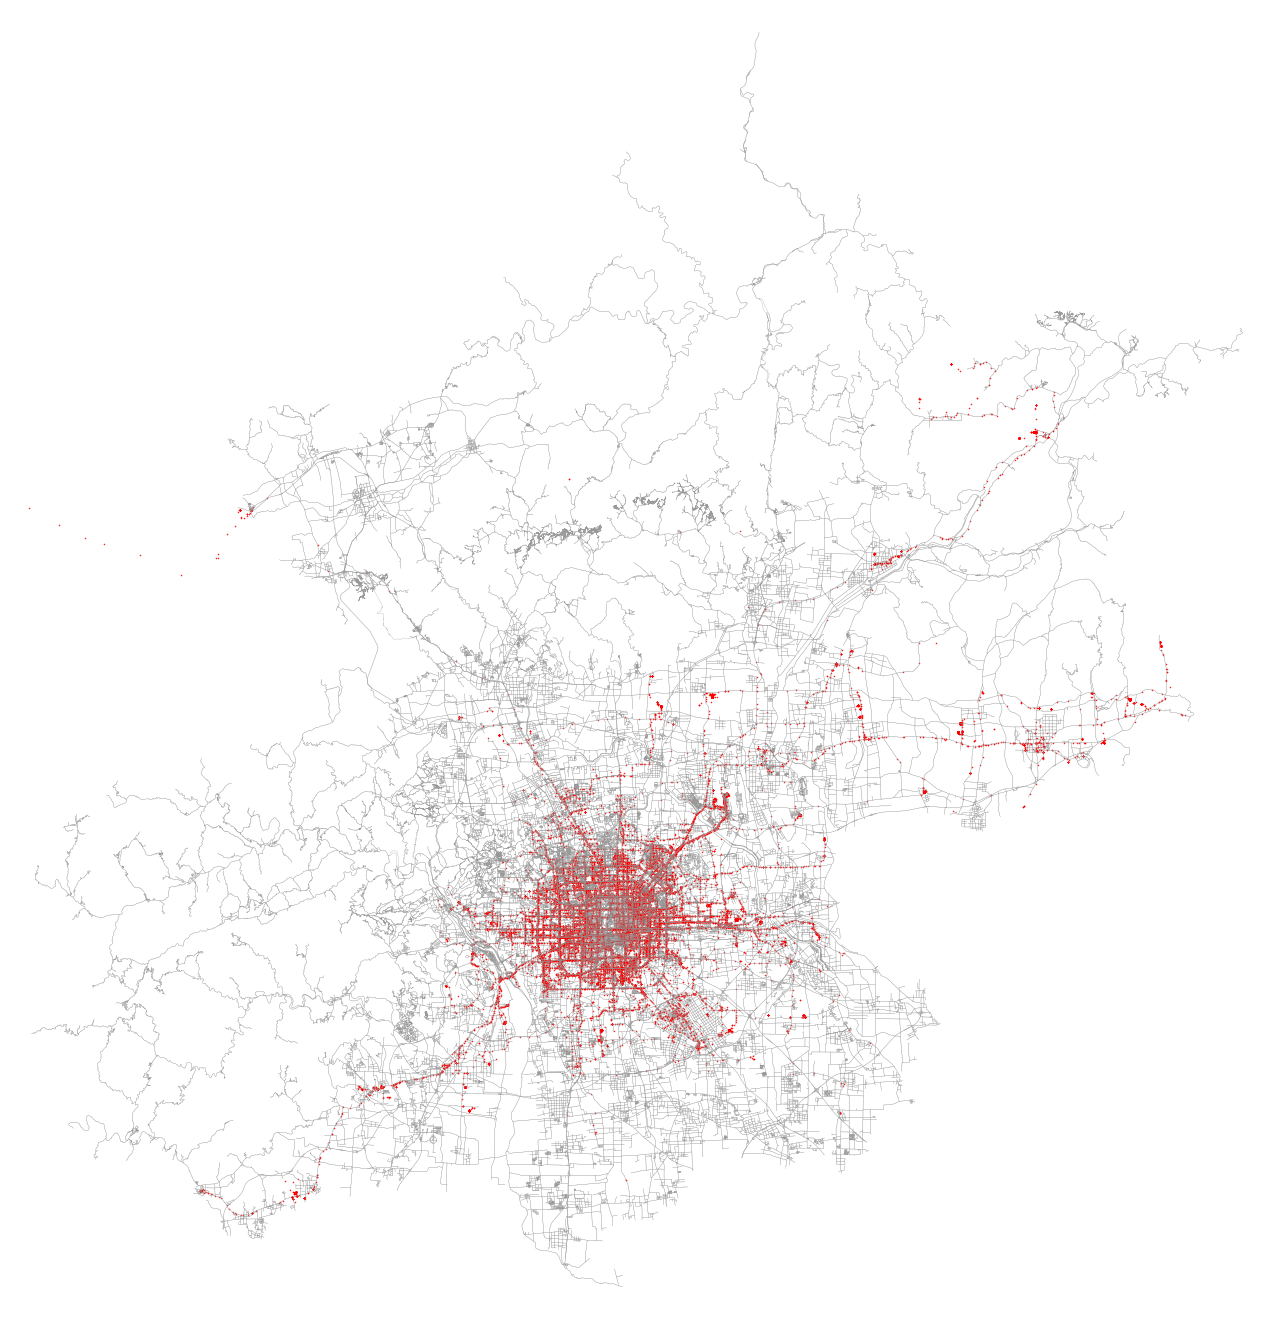

In [6]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

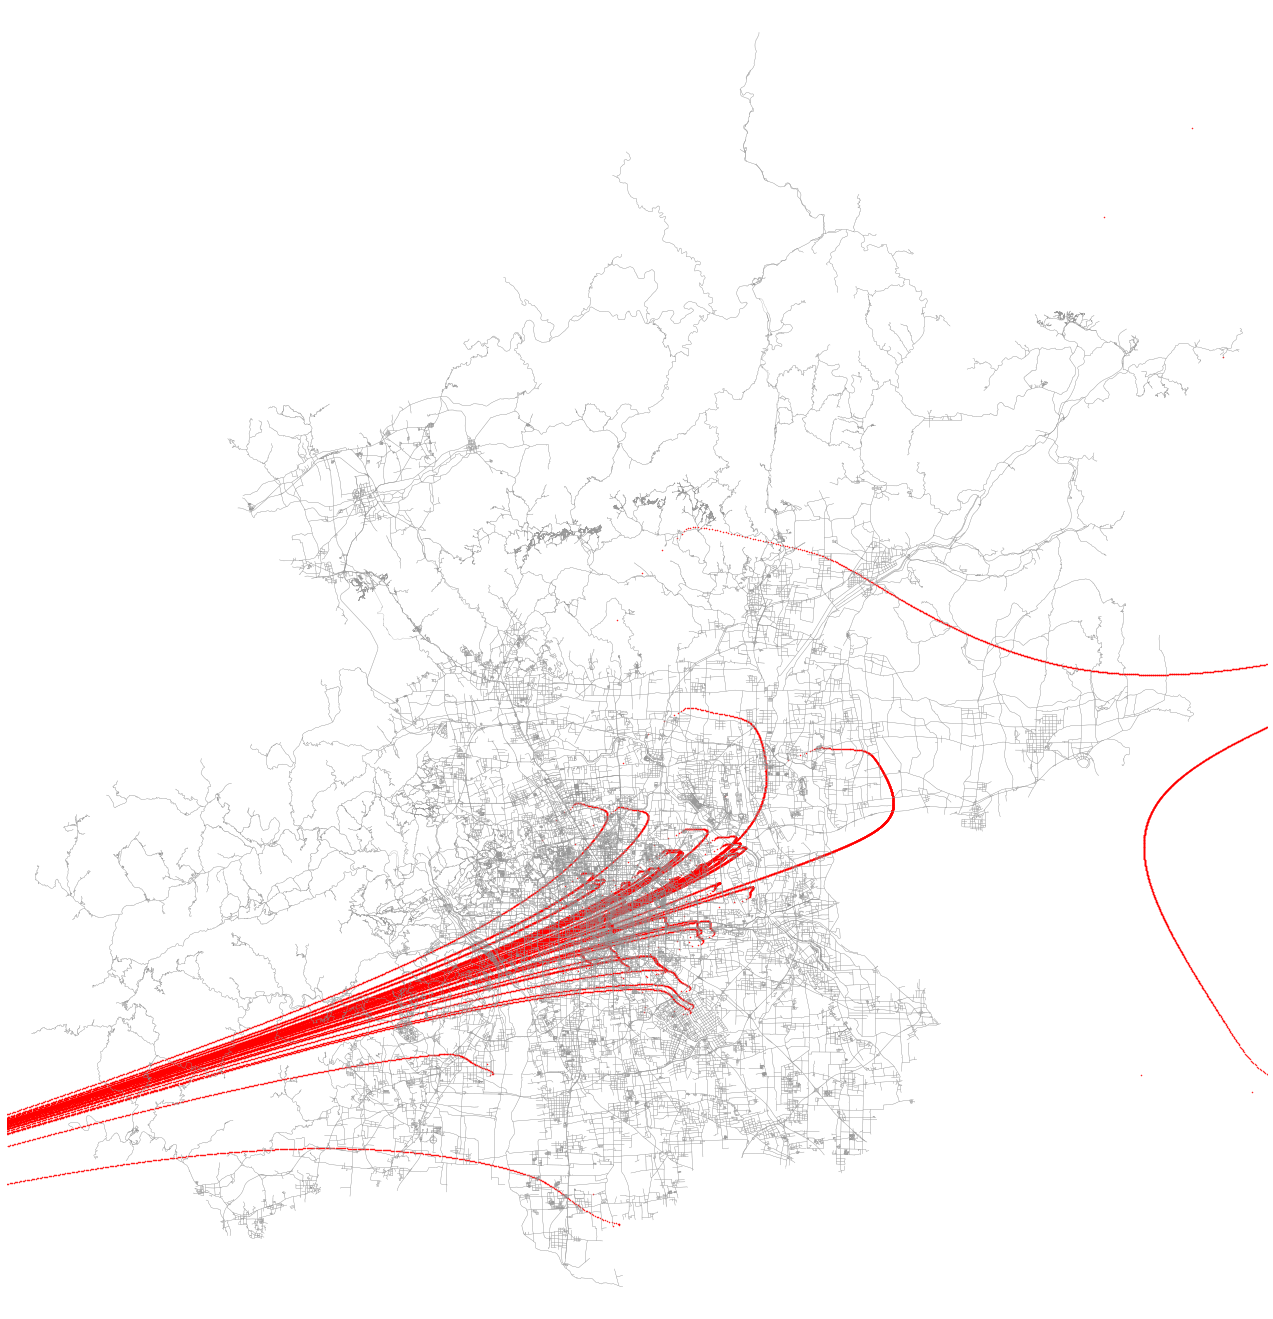

In [7]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

## Histogram of # records in every hour

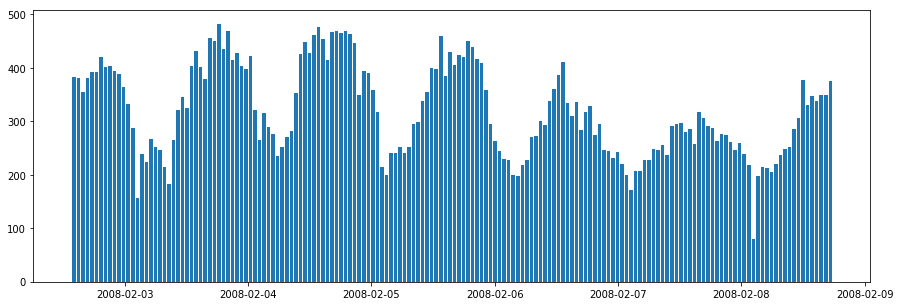

In [4]:
plt.figure(figsize=(15, 5))
plt.hist(real.index.levels[1], bins=168, edgecolor='white')
plt.show()

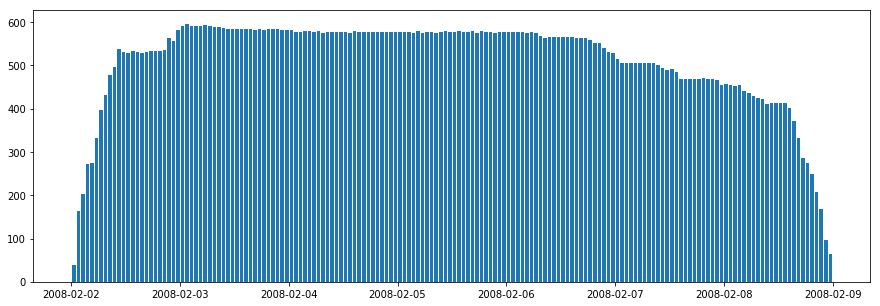

In [5]:
plt.figure(figsize=(15, 5))
plt.hist(fake.index.levels[1], bins=168, edgecolor='white')
plt.show()

## Distribution of speeds

In [8]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150), edgecolor='white')
    plt.show()

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    5.705200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      2.644532e-02
50%      2.067302e+00
75%      1.763089e+01
max               inf
dtype: float64


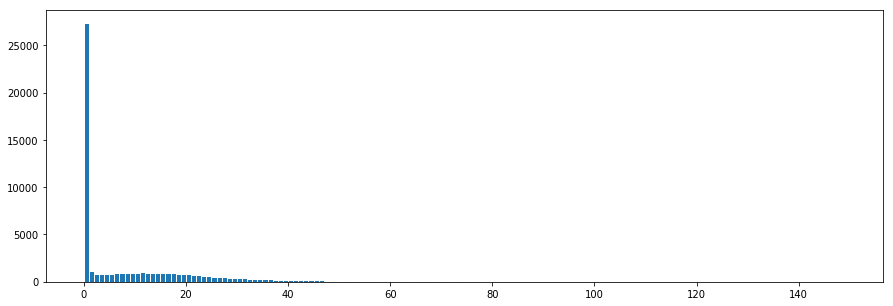

In [9]:
speed_distribution(real)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    8.659500e+04
mean     1.446026e+02
std      2.898554e+04
min      0.000000e+00
25%      1.263210e+00
50%      2.165792e+00
75%      3.026242e+00
max      6.796939e+06
dtype: float64


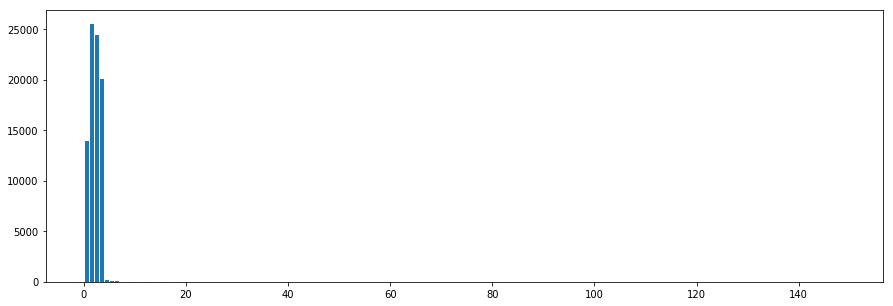

In [10]:
speed_distribution(fake)

## One user's data

In [11]:
real.index.levels[0]

Int64Index([  102,   229,   322,   412,   550,   609,   623,   674,   859,
             1023,  1088,  1208,  1218,  1283,  1326,  1606,  1764,  2257,
             2340,  3030,  3269,  3308,  3545,  3861,  4159,  4171,  4243,
             5047,  5140,  5891,  5914,  6585,  6598,  6749,  7159,  7365,
             7443,  8266,  8637,  8744,  8864,  8882,  8930,  9037,  9238,
             9363,  9786,  9988, 10123, 10334],
           dtype='int64', name='user')

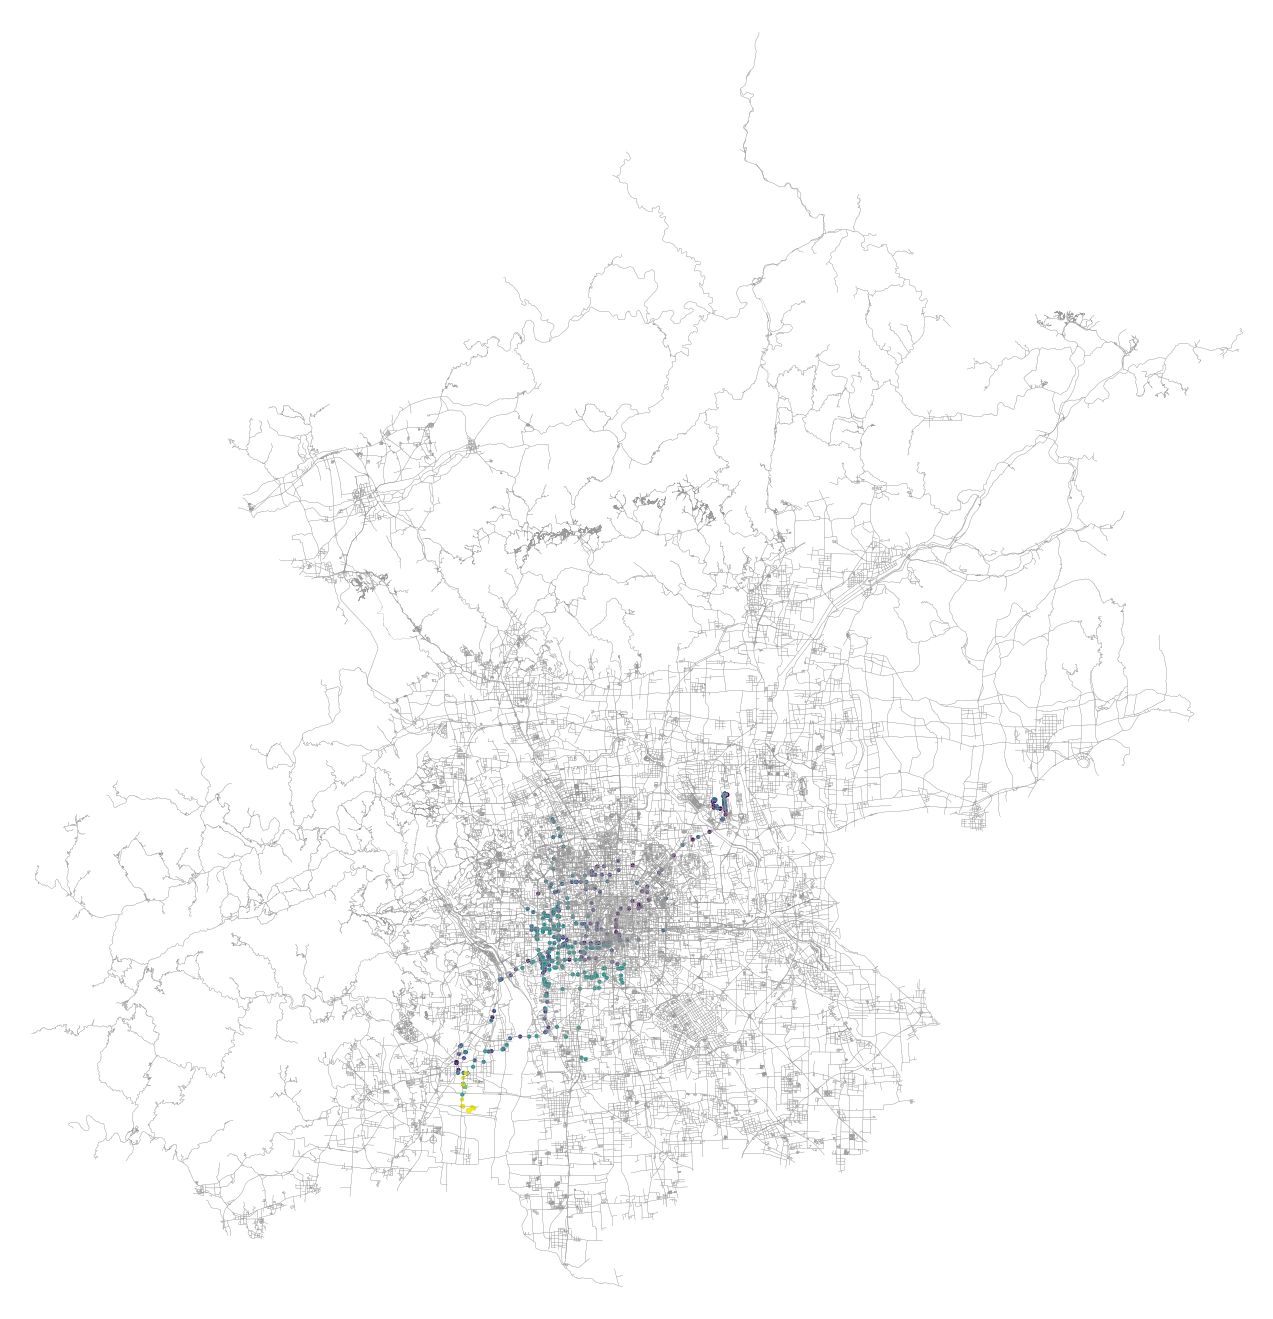

In [20]:
user = 623
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

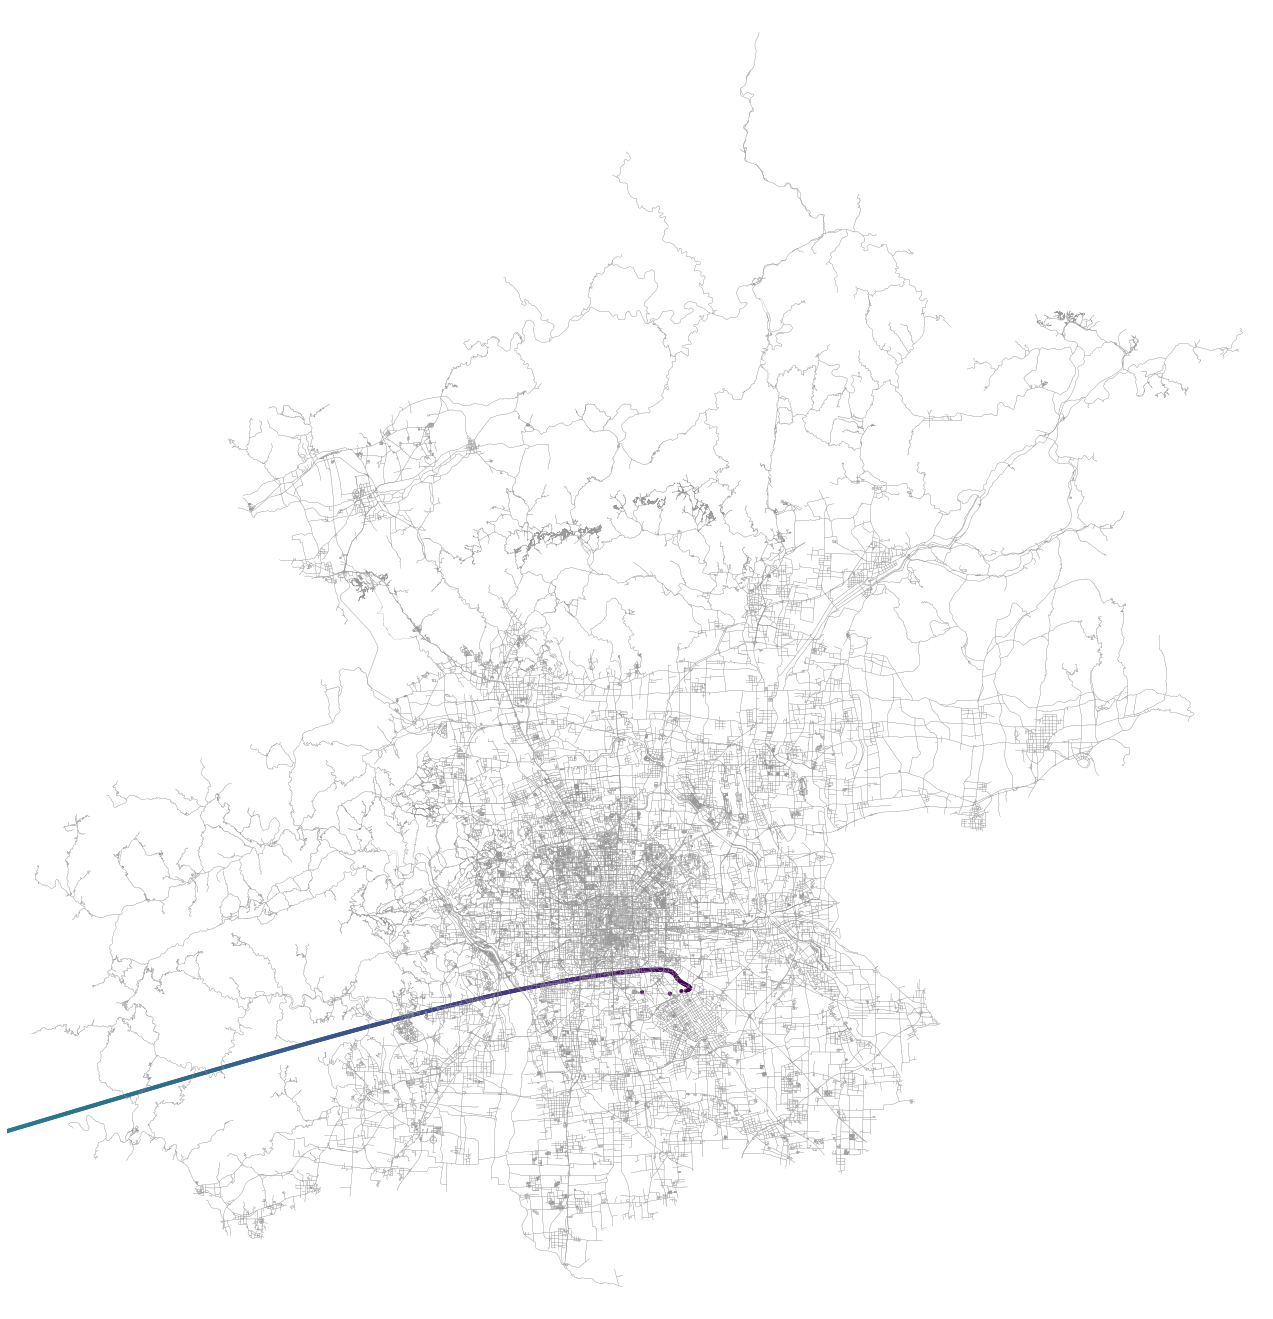

In [14]:
user = 24
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)